Synchrotron spectrum code written by Kaya Han Tas and Titus Veit.
Kaya wrote most of the Flat Jet Spectrum code and Titus wrote most of the SSC code.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import monte_carlo_utils
from scipy.integrate import quad

In [3]:
source_distance = 4 * 3.08567758e21 # distance in cm
source_mass = 4.7e3 # mass in solar masses

In [34]:
# We first define all the Constant values we have in cgs units!

q = 4.8e-10 # Electron Charge
mass_e = 9.1e-28 # Mass of electron
c = 3.0e10 # Speed of Light
velocity = 0.3 * c # Velocity of the Jet Plasma
p = 2.1 #From literature 
efficiency_factor = 1e-7
gamma = 1000 # Lorentz Factor from the Observations
h = 6.626e-34
mass_sun = 1.988e33 # The mass of the Sun in terms of cgs
G = 6.67e-8 # Gravitational Constant in terms of cgs
inclination_angle = 40

# We now find the Sgr A*'s parameters.
mass_acc = 5 * mass_sun / 1e16 # Mass Accretion Rate for the source
mass_acc = 2.3e-9 * mass_sun
edd_lum = 1.26e38 * source_mass # Eddington Luminosity

rg = (G*source_mass*mass_sun)/(c**2)  # Gravitational Radius of the source in cm

radius_initial = 10 * rg
print(format(radius_initial, "e"))

6.924646e+09


In [5]:
# Assume that we are starting from D = 10 rg to D = 1000 rg.
D = source_distance

# We also define an array for the length of the jet (which is the distance we
# cover but starting from the base which is zero).
z = np.logspace(-1, 3, 100) * rg # length

# From this, we can define our "Even Bin Slices"
# We can find the length difference (known as delta z) so basically the jet slice
# thickness per distance as follows.
delta_z = np.diff(z) # length_diff

# We also won't check the last length since we won't check the last slice.
z = z[0:-1]

# We get the first delta z
delta_z_initial = delta_z[0]

In [6]:
# Now we define the change in Radius in time.
# From geometry we can do the following:
# Since opening angle is 10 degrees and the half of it is 5 degrees,
# taking the tangent of that angle will be equal to R(t)/D(t) so the
# Radius divided by distance at the given time.
# From here we can find R(t) = tan(5 deg) * D(t)

def Radius(z):
    """
    Takes the distance and returns the Radius of the slice of the jet at that
    distance.
    """
    
    # Opening Angle of our source is 10.6 degrees.
    # Defining radius using R(t) = tan(10.6 deg) * D(t)
    radius_time = radius_initial + (z * np.tan(np.deg2rad(10.6)))

    return radius_time


def area_sphere(z):
    return 4 * math.pi * (Radius(z) ** 2)

In [7]:
# For Magnetic Field calculations, we will have to use the initial Magnetic Field
# and initial Area due to the conservation of the Magnetic Flux throughout the
# jet we have.

# We first find the initial Magnetic Field.
# For this we use the following formulae:
# -> U_total = U_e + U_b
# -> U_total = 2U_b (Due to Equipartition)
# -> U_total = 2(B^2/8π)

# We first find the initial Area.
Area_initial = np.pi * (radius_initial ** 2)

# Then we use this to find the initial Magnetic Field.
# Note that we split the Numerator and Denominator since it would be complicated
# for one line of code.
Magnetic_Field_initial_1 = 4 * np.pi * efficiency_factor * mass_acc * (c ** 2)
Magnetic_Field_initial_2 = Area_initial * velocity

Magnetic_Field_initial = np.sqrt(Magnetic_Field_initial_1/Magnetic_Field_initial_2)
print(Magnetic_Field_initial)

61759.609485006906


In [8]:
# Now we need to define the Source Function to find the Specific Intensity per
# slice.
# First, we need to define the Total Power of the jet.
# Since the Total Power of the Jet has two terms that depends on Radius,
# we define them first.

# First parameter that depends on Radius is the Magnetic Field.
def B(z, delta_z):
    """
    Takes the distance and calculates the Magnetic Field Strength
    at that distance.

    :param z:
    :param delta_z:
    :return:
    """

    # We first find the initial Area.
    Area_initial_B = radius_initial * delta_z_initial

    # Then we find the current Area of the jet.
    Area_B = Radius(z) * delta_z

    # Now we can find the Magnetic Field for every distance thanks to the
    # Magnetic Flux being conserved throughout the jet.
    magnetic_field = (Magnetic_Field_initial * Area_initial_B) / (Area_B)

    # print(Magnetic_Field_initial * Area_initial_B)
    # print(magnetic_field * Area_B)
    return magnetic_field

In [9]:
def Frequency(B):
    """
    Takes the distance and calculates the Frequency Interval, using the
    initial and final Magnetic Field Strength.

    :param B:
    :return:
    """

    # We get the Magnetic Field Strength array.
    magnetic_field_array = B

    # We find the lower and upper frequency limits.
    lower_frequency = (3*(1**2)*q*magnetic_field_array[-1])/(2*mass_e*c)
    upper_frequency = (3*(gamma**2)*q*magnetic_field_array[0])/(2*mass_e*c)

    # We divide by 2pi since it is the Angular Frequency
    lower_frequency = lower_frequency/(2*np.pi)
    upper_frequency = upper_frequency/(2*np.pi)

    # We find the frequency interval that is in logspace.
    lower_frequency = format(lower_frequency, "e")
    upper_frequency = format(upper_frequency, "e")

    # We strip the exponential part of the frequencies.
    lower_frequency = (lower_frequency.split("e"))
    upper_frequency = (upper_frequency.split("e"))

    # Now we get the exponent part of the frequencies.
    lower_frequency = int(lower_frequency[1])
    upper_frequency = int(upper_frequency[1])

    # Now we use these to find the frequency interval.
    # frequency = np.logspace(lower_frequency, upper_frequency, 100)
    frequency = np.logspace(4, 16, 10000)

    return frequency[0:-1]

In [10]:
# Next, we define the Normalization Constant for the Power.
def C(B):
    """
    Takes the distance and calculates the Normalization Constant for Power
    so "C" at that time.

    :param B:
    :return:
    """

    # Assuming Equipartition, since U_e = U_b we can write the following for the
    # first part of the normalization constant C hat.
    normalization_constant_1 = (B**2) / (8*np.pi)

    # We need to divide U_e with the logarithm of the Lorentz Factor we have.
    # For that we write the second part of the normalization constant.
    normalization_constant_2 = np.log(gamma)

    # From here, C hat can be written as follows.
    normalization_constant = normalization_constant_1 / normalization_constant_2

    # So far we got the C hat.
    # Since C is equal to C hat divided by the mass of electron and speed of
    # light squared we can write the following.
    normalization_constant = normalization_constant / (mass_e * (c ** 2))

    return normalization_constant

In [11]:
# Now we can also define the Normalization Constant for Absorption Coefficient.
def C_hat(B):
    """
    Takes the distance and calculates the Normalization Constant for
    Absorption Coefficient so "C hat" at that time.

    :param B:
    :return:
    """

    # Assuming Equipartition, since U_e = U_b we can write the following for the
    # first part of the normalization constant C hat.
    normalization_constant_1 = (B**2) / (8*np.pi)

    # We need to divide U_e with the logarithm of the Lorentz Factor we have.
    # For that we write the second part of the normalization constant.
    normalization_constant_2 = np.log(gamma)

    # From here, C hat can be written as follows.
    normalization_constant = normalization_constant_1 / normalization_constant_2

    return normalization_constant

In [12]:
# Now we define the Absorption Coefficient. (Using the formula from the question)
def alpha_nu(B, C_hat, frequency):
    """
    Takes the distance and the frequency, then calculates the Absorption
    Coefficient at that distance and frequency.

    :param B:
    :param C_hat:
    :param frequency:
    :return:
    """

    # We will split all the multiplications to avoid writing the whole equation
    # in one line.
    abs_coeff_1 = (np.sqrt(3)*pow(q,3))/(8*np.pi*mass_e)
    abs_coeff_2 = ((3*q)/(2*math.pi*pow(mass_e,3)*pow(c,5))) ** (p/2)
    abs_coeff_3 = C_hat
    abs_coeff_4 = (B*np.sin(inclination_angle)) ** ((p+2)/2)
    abs_coeff_5 = math.gamma(((3*p+2)/12)) * math.gamma(((3*p+22)/12))
    abs_coeff_6 = frequency ** (-(p+4)/2)

    # Absorption Coefficient
    abs_coeff = abs_coeff_1 * abs_coeff_2 * abs_coeff_3 * abs_coeff_4 * abs_coeff_5 * abs_coeff_6

    return abs_coeff

In [13]:
def P_total(B, C, frequency):
    """
    Takes the distance and the frequency, then calculates the Total Power
    at that distance and frequency.

    :param B:
    :param C:
    :param frequency:
    :return:
    """

    # We will split all the multiplications to avoid writing the whole equation
    # in one line.
    total_power_1 = (1e-22)/(p+1)
    total_power_2 = C
    total_power_3 = B
    total_power_4 = ((1e-7 * frequency)/(B)) ** (-(p-1)/2)

    # Total Power
    total_power = total_power_1 * total_power_2 * total_power_3 * total_power_4

    return total_power

In [14]:
def S_nu(P_total, alpha_nu):
    """
    Takes the distance and the frequency, then calculates the Source Function
    at that distance and frequency.

    :param P_total:
    :param alpha_nu:
    :return:
    """

    source_function = P_total / (4 * np.pi * alpha_nu)

    return source_function

In [15]:
# Now we also can get the Optical Depth.
def tau(alpha_nu, Radius):
    """
    Takes the distance and frequency, then calculates the Optical Depth at
    that distance and frequency.

    :param alpha_nu:
    :param Radius:
    :return:
    """

    optical_depth = alpha_nu * Radius

    return optical_depth

In [16]:
# We can now define the Intensity at given distance!
def I_nu(S_nu, tau):
    """
    Takes the distance and frequency, then calculates the Specific Intensity
    at that distance and frequency.

    :param S_nu:
    :param tau:
    :return:
    """

    specific_intensity = S_nu * (1 - np.exp(-tau))

    return specific_intensity

In [17]:
# From here, we finally define our Flux which depends on Intensity, Area of
# the emitting surface and our distance to the slice.

def Flux(I_nu, radius, delta_z, D):
    """
    Takes the distance array then calculates the Flux at that frequency interval.

    :param I_nu:
    :param radius:
    :param delta_z:
    :param D:
    :return:
    """

    # Now we find the flux for each frequency in order to create an array of our
    # frequency and flux values, which will give us the spectrum for that
    # distance.

    # We also do the conversion from erg/cm^2 to mJy here.
    # (1 Jy = 1e-23 erg/cm^2 => 1 mJy = 1e-26 erg/cm^2)
    flux_1 = (4 * np.pi) * ((I_nu)/1e-26)
    flux_2 = (2 * np.pi * radius * delta_z * np.sin((inclination_angle * math.pi / 180)))
    flux_3 = (4 * np.pi * (D**2))

    #  We add the fluxes to our flux_distance array, which will be an array
    # that gives us the spectrum for that distance.
    flux_distance = (flux_1 * flux_2)/(flux_3)

    return flux_distance

In [18]:
def calc_I_for_slice(B_for_slice, radius_for_slice):
    """
    Function to calculate the intensity of a slice.

    :param B_for_slice:
    :param radius_for_slice:
    :return:
    """
    freq_for_slice = full_freq
    C_for_slice = C(B_for_slice)
    C_hat_for_slice = C_hat(B_for_slice)

    P_total_for_slice = P_total(B_for_slice, C_for_slice, freq_for_slice)
    alpha_nu_for_slice = alpha_nu(B_for_slice, C_hat_for_slice, freq_for_slice)

    S_nu_for_slice = S_nu(P_total_for_slice, alpha_nu_for_slice)

    tau_for_slice = tau(alpha_nu_for_slice, radius_for_slice)

    return I_nu(S_nu_for_slice, tau_for_slice), freq_for_slice

In [19]:
def calc_flux_for_slice(B_for_slice, radius_for_slice, dz):
    """
    Function to calculate the flux of a slice.

    :param B_for_slice:
    :param radius_for_slice:
    :param dz:
    :return:
    """
    freq_for_slice = full_freq
    C_for_slice = C(B_for_slice)
    C_hat_for_slice = C_hat(B_for_slice)

    P_total_for_slice = P_total(B_for_slice, C_for_slice, freq_for_slice)
    alpha_nu_for_slice = alpha_nu(B_for_slice, C_hat_for_slice, freq_for_slice)

    S_nu_for_slice = S_nu(P_total_for_slice, alpha_nu_for_slice)

    tau_for_slice = tau(alpha_nu_for_slice, radius_for_slice)

    I_nu_for_slice = I_nu(S_nu_for_slice, tau_for_slice)

    # We find the flux for the given distance.
    return Flux(I_nu_for_slice, radius_for_slice, dz, D), freq_for_slice

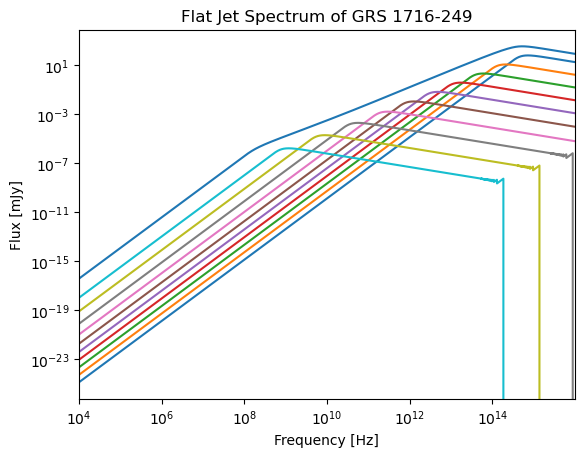

In [20]:
# Now for every distance we have, we will calculate a spectrum.
# Every distance means a slice, we will add them up in order to get our
# complete spectrum of the jet.
full_freq = Frequency(B(z, delta_z))

# We define a new array for our total flux for all slices.
total_flux = np.zeros(len(full_freq))
for i in range(len(z)):
    # We define an array for the summary of the fluxes.
    total_flux_distance = np.zeros(len(total_flux))

    B_for_slice = B(z[i], delta_z[i])
    radius_for_slice = Radius(z[i])

    # We find the flux for the given distance.
    flux, f_for_slice = calc_flux_for_slice(B_for_slice, radius_for_slice, delta_z[i])

    # We add the fluxes to our total_flux_distance array.
    total_flux_distance = np.add(total_flux_distance, flux)

    # Now we add the values to our Total Flux array.
    total_flux = np.add(total_flux, flux)

    if i % 10 == 0:
        plt.plot(f_for_slice, flux)

# We plot the Frequency with Flux.
# (1 Jy = 1e-23 erg/cm^2)
plt.plot(Frequency(B(z, delta_z)), total_flux)

# We also add Labels and Title.
plt.title("Flat Jet Spectrum of GRS 1716-249")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Flux [mJy]")
plt.xscale("log")
plt.yscale("log")
plt.margins(x=0)

plt.show()

In [21]:
B_for_slice = B(z[0], delta_z[0])
radius_for_slice = Radius(z[0])

I_first_slice, f_first_slice = calc_I_for_slice(B_for_slice, radius_for_slice)

In [22]:
def SSC(x):
    """
    Photon distribution function using the flux of a slice.

    :param float x: Photon energy
    :return array: Differential photon number dN/de at energy e
    """
    return np.interp(x, mc_parms['f'], mc_parms['I'])

def p_SSC():
    """
    Numerical integration of cumulative planck PDF (to be inverted)

    Parameters:
        hnu (numpy array): bins of photon energy e in untis of kT

    Returns:
        numpy array: cumulative photon PDF as function of hnu
        numpy array: hnu values used for PDF
    :return:
    """
    number = 1000
    hnu = np.append(np.linspace(0, 1 - 1. / number, number), np.logspace(0, 4, number))

    p = np.zeros(2 * number)
    for i in range(1, 2 * number):
        p[i] = ((quad(SSC, 0, hnu[i]))[0])

    return p, hnu


def hnu_of_p_SSC(number=None, pdf=None, hnu=None):
    if number is None:
        number = 1
    if pdf is None:
        pdf, hnu = p_SSC()

    e_phot = np.interp(np.random.rand(number), pdf, hnu)
    return e_phot, pdf, hnu


def f_of_hnu_SSC(mc_parms, number=None, pdf=None, energies=None):
    if number is None:
        number = 1
    if pdf is None:
        e, pdf, energies = hnu_of_p_SSC(number=number)
    else:
        e, pdf, energies = hnu_of_p_SSC(number=number, pdf=pdf, hnu=energies)
    e *= mc_parms['kt_seeds']
    return e / 1e4

In [23]:
# Define the Electron Power Distribution.
def power_Law(x):
    """
    Returns
    :param x:
    :return:
    """
    # We get the electron number per energy as follows.
    return C(B(z[0], delta_z[0])) * (x * mass_e * (c ** 2)) ** -p


def inverse_transform_sampling():
    gamma_range = np.random.uniform(1, 100)
    e_elec = power_Law(gamma_range)
    return e_elec


def f_of_v_power(mc_parms):
    # We get the electron number per energy as follows.
    v = 3e10
    while v >= c:
        gamma_value_1 = mc_parms['C'] / inverse_transform_sampling()
        gamma_value_2 = mass_e * (c ** 2)

        gamma_value_3 = gamma_value_1 ** (1/p)

        gamma_value = gamma_value_3 / gamma_value_2

        v = np.sqrt(1 - (1 / (gamma_value ** 2))) * c

    return v

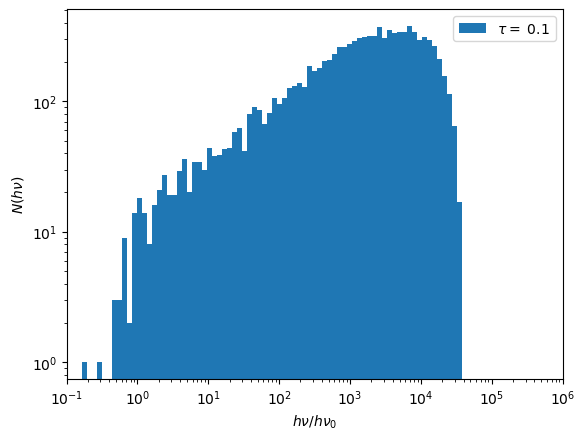

Fraction of escaping photons: 1.000e+00

Compton y parameter: 4.499e+03



In [32]:
mc_parms = {
    'n_photons': 10000,  # start somewhat small and go up
    'kt_seeds': 1.6e-9,  # 1 keV input photons
    'H': 1e7,  # say H ~ R, and R ~ 100 R_g ~ 3e7 cm
    'tau': 0.1,  # tau ~ 0.1: Small-ish optical depth
    'kt_electron': 3.2e-8,  # 20 keV
    'v_dist': f_of_v_power,  # name of velocity distribution function
    'hnu_dist': f_of_hnu_SSC,  # name of photon distribution function
    'I': I_first_slice,
    'f': f_first_slice,
    'C': C(B(z[0], delta_z[0]))
}

hnu_scattered, hnu_seeds = monte_carlo_utils.plot_mc_ssc(mc_parms, xlims=[1e-1, 1e6])

In [25]:
def freq_SSC(hnu_scattered):
    """
    Function to calculate the frequency interval for SSC.

    :param hnu_scattered:
    :return:
    """
    #We divide the frequency of the scattered photons by Planck Constant to get 
    #the frequency interval for the SSC.
    frequency_interval = hnu_scattered/h
    
    return frequency_interval

freq_SSC(hnu_scattered)

array([1.19117803e+36, 2.99580265e+37, 1.02395002e+37, ...,
       1.69504834e+35, 3.69404160e+35, 5.74425390e+32])

In [26]:
def freq_all():
    """
    Function to define a general frequency interval for both SSA and SSC.

    :param:
    :return:
    """
    freq_all = np.logspace(3, 25, 10000)
    return freq_all

freq_all()

array([1.00000000e+03, 1.00507905e+03, 1.01018389e+03, ...,
       9.89918772e+24, 9.94946618e+24, 1.00000000e+25])

In [27]:
def calc_flux_for_slice_ssc(B_for_slice, radius_for_slice, dz, hnu_scattered, freq_SSC):
    """
    Function to calculate the SSC flux of a slice.

    :param B_for_slice:
    :param radius_for_slice:
    :param dz:
    :return:
    """
    freq_for_slice = freq_SSC
    C_for_slice = C(B_for_slice)
    C_hat_for_slice = C_hat(B_for_slice)

    P_total_for_slice = P_total(B_for_slice, C_for_slice, freq_for_slice)
    alpha_nu_for_slice = alpha_nu(B_for_slice, C_hat_for_slice, freq_for_slice)

    S_nu_for_slice = S_nu(P_total_for_slice, alpha_nu_for_slice)

    tau_for_slice = tau(alpha_nu_for_slice, radius_for_slice)
    
    #We calculate the intensity for SSC.
    #For this we use the scattered photon numbers and multiply that with hν to
    #calculate the Intensity we get for each frequency on given slice.
    I_nu_for_slice = hnu_scattered * h * freq_SSC

    # We find the flux for the given distance.
    return Flux(I_nu_for_slice, radius_for_slice, dz, D), freq_for_slice

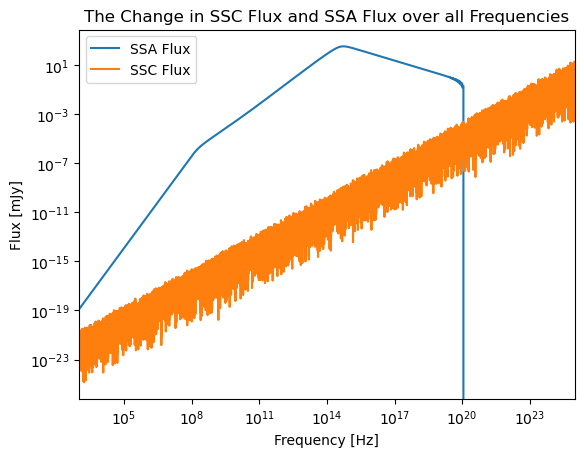

In [28]:
#We plot the SSC and SSA together to get the full spectrum.
plt.figure()

#We first define the frequency interval which is the frequency interval we
#want for SSA and SSC plot.
full_freq = freq_all()

#------------------------------------------------------------------------------
#For SSA:

#We define a new array for our total flux (SSA) for all slices.
total_flux = np.zeros(len(full_freq))

for i in range(len(z)):
    # We define an array for the summary of the fluxes.
    total_flux_distance = np.zeros(len(total_flux))

    B_for_slice = B(z[i], delta_z[i])
    radius_for_slice = Radius(z[i])

    # We find the flux for the given distance.
    flux, f_for_slice = calc_flux_for_slice(B_for_slice, radius_for_slice, delta_z[i])

    # We add the fluxes to our total_flux_distance array.
    total_flux_distance = np.add(total_flux_distance, flux)

    # Now we add the values to our Total Flux array.
    total_flux = np.add(total_flux, flux)

#We plot the SSC
plt.plot(freq_all(), total_flux, label = "SSA Flux")

#------------------------------------------------------------------------------
#For SSC:

#We define a new array for our total flux (SSC) for all slices.
total_flux_ssc = np.zeros(len(full_freq))

for i in range(len(z)):
    total_flux_distance = np.zeros(len(total_flux_ssc))

    B_for_slice = B(z[i], delta_z[i])
    radius_for_slice = Radius(z[i])

    # We find the flux for the given distance.
    flux, f_for_slice = calc_flux_for_slice_ssc(B_for_slice, radius_for_slice, delta_z[i], hnu_scattered, full_freq)

    # We add the fluxes to our total_flux_distance array.
    total_flux_distance = np.add(total_flux_distance, flux)

    # Now we add the values to our Total Flux array.
    total_flux_ssc = np.add(total_flux_ssc, flux)

#We plot the SSC
plt.plot(freq_all(), total_flux_ssc, label = "SSC Flux")

#------------------------------------------------------------------------------

# We also add Labels and Title.
plt.title("The Change in SSC Flux and SSA Flux over all Frequencies")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Flux [mJy]")
plt.xscale("log")
plt.yscale("log")
plt.legend(loc = "upper left")
plt.margins(x=0)
plt.show()

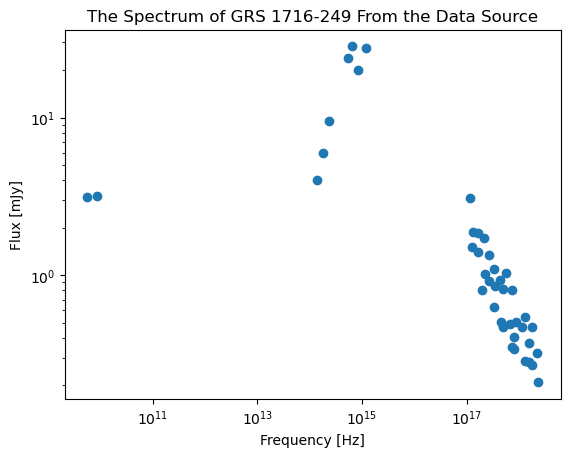

In [29]:
#The Data from the Paper is as follows.
data="""
5578004666.282427:1.752515920029344e-16
8783386058.472559:2.783863182321306e-16
138307289555543.22:5.567161278311044e-12
179275576093496.88:1.0621777091969023e-11
232379162999561.06:2.2220844661808026e-11
540000753963767.9:1.2840784257327016e-10
655996328108286.2:1.8578647061087557e-10
850310348895982.5:1.6965921951802037e-10
1176041196368316.2:3.238036128803968e-10
117604119636831630:3.6331362922145477e-9
133893829616415170:2.5151470429792006e-9
125484923225232290:1.907315487180231e-9
210835462988616100:3.643756071641611e-9
162655070275361500:2.2960741834374863e-9
162655070275361500:3.0268152645418606e-9
197594407166312350:1.5900414676810188e-9
224963819022518400:2.299800377076058e-9
331991344044538500:3.6520373565586937e-9
273287468865072900:3.6484859323115094e-9
273287468865072900:2.524135564935152e-9
459168229507023200:2.3080193025823547e-9
489937684199197440:4.012178826554739e-9
331991344044538500:2.1015281476110897e-9
354238511775937860:3.038617651404998e-9
557800466628238100:5.80312562015411e-9
677619531527112300:3.3426007558018653e-9
878338605847252200:4.41212580640418e-9
723027689439601700:5.810658499713988e-9
723027689439601700:2.5364444308660487e-9
489937684199197440:2.3087679325381253e-9
1296212055558350800:3.676994309409437e-9
1138513089761532300:5.3114276197378845e-9
1296212055558350800:7.00636821675407e-9
1574646595684256800:5.833315858538158e-9
1574646595684256800:4.425022598349147e-9
2177851026569529000:7.024569574543694e-9
1792755760934961700:8.437177447098572e-9
1792755760934961700:4.855088861460874e-9
2323791629995601000:4.861391120284786e-9
823176488687029200:2.782960500270988e-9
823176488687029200:3.345854432420892e-9
430331182491554400:4.009577308885789e-9"""

#We split the data into lines
lines = data.strip().split('\n')

#We extract the values before and after the colon (Frequency and Flux)
frequency_data = np.array([float(line.split(':')[0]) for line in lines])
flux_data = np.array([float(line.split(':')[1]) for line in lines])

#We need to convert Flux data (which is multiplied by the frequency) into
#mJy from ergs!
flux_data = flux_data/frequency_data
flux_data = flux_data/1e-26

#Now we plot the data.
plt.figure()

plt.plot(frequency_data, flux_data, "o")

plt.xscale("log")
plt.yscale("log")

plt.title("The Spectrum of GRS 1716-249 From the Data Source")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Flux [mJy]")

plt.show()

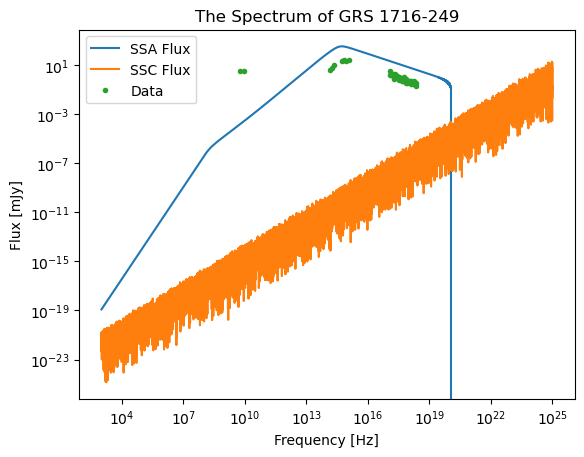

In [30]:
#Now we plot the SSA/Flat Jet, SSC and Data all together.
plt.figure()

plt.plot(freq_all(), total_flux, label = "SSA Flux")
plt.plot(freq_all(), total_flux_ssc, label = "SSC Flux")
plt.plot(frequency_data, flux_data, ".", label = "Data")

plt.xscale("log")
plt.yscale("log")

plt.title("The Spectrum of GRS 1716-249")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Flux [mJy]")

plt.legend(loc = "upper left")

plt.show()